# EDA4

Explained Variance Ratio: [0.12671289 0.11381647]


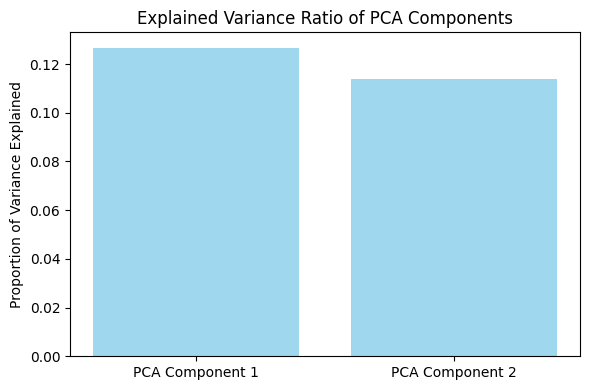

Top contributing features for each PCA component:

PCA Component 1:
pnr_size                                 0.919738
journey_type_id_One-way                  0.215683
booking_system_other                     0.092528
booking_system_source_type_API           0.089952
brand_B                                  0.052992
client_entry_type_metasearch             0.051781
order_amount                             0.042735
partner_C                                0.038585
booking_system_source_type_Web scrape    0.032851
origin_country_other                     0.031325
Name: PCA Component 1, dtype: float64

PCA Component 2:
order_amount                      0.987134
client_entry_type_metasearch      0.044901
currency_other                    0.043039
origin_country_other              0.041078
booking_system_source_type_GDS    0.039009
partner_C                         0.032982
booking_system_A                  0.032763
brand_B                           0.032283
brand_D                         

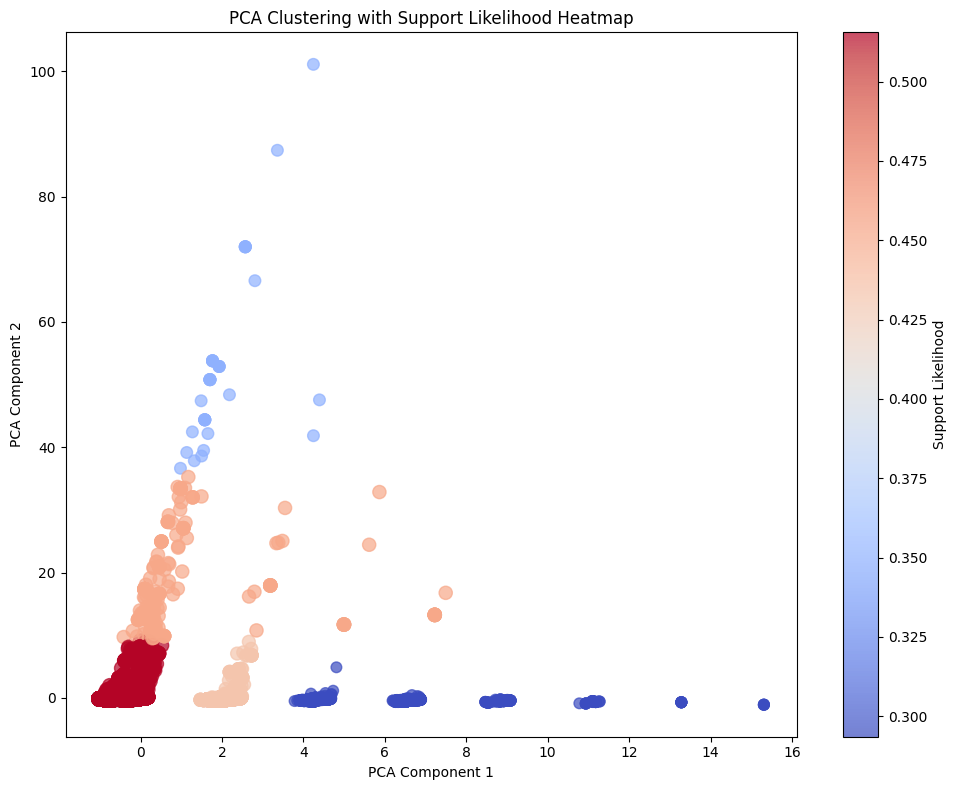

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

def process_and_cluster_with_explained_variance(data, sample_size=None):
    """
    Process a dataset, perform PCA with clustering, and visualize results along with explained variance.
    
    Args:
        data (pd.DataFrame): The input dataset.
        sample_size (int, optional): If provided, sample the data for memory efficiency.
    
    Returns:
        None
    """
    # Drop unnecessary columns
    X = data.drop(
        columns=[
            "count_errands",
            "zero_errands",  # Target column
            "order_id",
            "change_reason",
            "cancel_reason",
            "is_canceled",
            "is_changed",
        ]
    )
    y = data["zero_errands"]

    # Sampling
    if sample_size:
        X, y = X.sample(n=sample_size, random_state=42), y.sample(n=sample_size, random_state=42)

    # Select categorical and numerical features
    categorical_features = X.select_dtypes(include=["object", "category"]).columns
    numeric_features = [col for col in X.columns if col not in categorical_features]

    # Handle categorical variables
    max_categories = 10  # Limit for one-hot encoding
    processed_cats = []
    for col in categorical_features:
        top_categories = X[col].value_counts().nlargest(max_categories).index
        X[col] = np.where(X[col].isin(top_categories), X[col], "other")
        processed_cats.append(pd.get_dummies(X[col], prefix=col))
    encoded_cats = pd.concat(processed_cats, axis=1)

    # Scale numerical variables
    scaler = StandardScaler()
    scaled_nums = scaler.fit_transform(X[numeric_features])

    # Combine processed features
    X_combined = np.hstack([scaled_nums, encoded_cats.values])
    feature_names = numeric_features + list(encoded_cats.columns)

    # Oversample to balance the target variable
    ros = RandomOverSampler(random_state=42)
    X_balanced, y_balanced = ros.fit_resample(X_combined, y)

    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_balanced)

    # Explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio: {explained_variance}")

    # Bar plot of explained variance
    plt.figure(figsize=(6, 4))
    plt.bar(
        ["PCA Component 1", "PCA Component 2"],
        explained_variance,
        color="skyblue",
        alpha=0.8,
    )
    plt.title("Explained Variance Ratio of PCA Components")
    plt.ylabel("Proportion of Variance Explained")
    plt.tight_layout()
    plt.show()

    # Analyze top features for each PCA component
    components_df = pd.DataFrame(pca.components_, columns=feature_names, index=["PCA Component 1", "PCA Component 2"])
    print("Top contributing features for each PCA component:")
    for component in components_df.index:
        top_features = components_df.loc[component].nlargest(10)  # Top 10 positive weights
        print(f"\n{component}:")
        print(top_features)

    # Clustering
    kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust clusters as needed
    clusters = kmeans.fit_predict(X_pca)

    # Add PCA and cluster info to the dataframe
    pca_df = pd.DataFrame(X_pca, columns=["pca1", "pca2"])
    pca_df["cluster"] = clusters
    pca_df["zero_errands"] = y_balanced

    # Compute support likelihood per cluster
    cluster_support = pca_df.groupby("cluster")["zero_errands"].mean().reset_index()
    cluster_support.columns = ["cluster", "support_likelihood"]

    # Merge likelihood back into the dataframe
    pca_df = pca_df.merge(cluster_support, on="cluster")

    # Visualization with clustering
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        x=pca_df["pca1"],
        y=pca_df["pca2"],
        c=pca_df["support_likelihood"],
        cmap="coolwarm",
        s=pca_df["support_likelihood"] * 200,  # Scale sizes for better visualization
        alpha=0.7,
    )
    # Add colorbar
    cbar = plt.colorbar(scatter, label="Support Likelihood")

    # Add labels and title
    plt.title("PCA Clustering with Support Likelihood Heatmap")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.tight_layout()
    plt.show()

# Load the dataset
df = pd.read_parquet("data/orders_ml.parquet")

# Process and visualize
process_and_cluster_with_explained_variance(df, sample_size=100000) # Adjust sample_size as needed, drop it for full dataset

